### Tutorial 5 - Sentiment & Frequency of Topics over Time

**Possible research questions:**
- *How does sentiment fluctuate over time across countries, and are there periods of particularly positive or negative sentiment globally or within specific countries?*
- *How do countries differ in their relative emphasis on CAP categories (proportion of speech devoted to each topic), and are certain categories consistently over- or under-represented across countries?*

In this tutorial, we will:
- **Load and read the datasets**
- **(Optional)** Calculate the overlapping time span of all datasets)
- **Choose a timeframe** and plot the sentiment over time across all countries 
    1) For **all topics**
    2) For **one specific topic**
- **Average Sentiment Scores by Country and CAP category**
    - Compute the mean sentiment for each CAP category in each country
    - Visualize using heatmaps to identify which countries have more positive/negative sentiment in which CAP categories
- **Avg. weekly word count**
    - For all countries 
    - For one chosen country and across all topics

**1. Setup**

First, we have to set up the requirements: install and load all necessary packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import csv
from pathlib import Path

**2. Data Loading & Filtering**

Now, we **read and filter** the data. This code:
- loads the selected columns of the datasets and merges them into a single DataFrame.
- selects only those that were held by Regular MPs (*Members of Parliament*) and filters out the CAP categories "Mix" and "Other". 
- creates separate DataFrames for coalition and opposition party speeches.


In [2]:
# ---- 1. First, we have to increase the CSV field size limit ----
max_int = 2**31 - 1
while True:
    try:
        csv.field_size_limit(max_int)
        break
    except OverflowError:
        max_int = max_int // 10

countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES-CT", "ES-GA", "ES-PV", 
             "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", 
             "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA"] #change country codes according to your available datasets

base_dir = Path().resolve()

# ---- 2. Choose what columns to read (including CAP and sentiment columns) ----
cols_to_keep = [
    "id", "date", "lang_code", "lang", "speaker_role", "speaker_MP",
    "speaker_minister", "speaker_party", "speaker_party_name", "party_status",
    "party_orientation", "speaker_id", "speaker_name", "speaker_gender",
    "speaker_birth", "word_count", "CAP_category", "sent3_category", "sent6_category", "sent_logit"
]

# ---- 3. Define dtypes to reduce memory ----
dtypes = {
    "id": str,
    "date": str,
    "lang_code": "category",
    "lang": "category",
    "speaker_role": "category",
    "speaker_MP": "category",
    "speaker_minister": "category",
    "speaker_party": "category",
    "speaker_party_name": "category",
    "party_status": "category",
    "party_orientation": "category",
    "speaker_id": "category",
    "speaker_name": "category",
    "speaker_gender": "category",
    "speaker_birth": "Int32",
    "word_count": "Int32",
    "CAP_category": "category",
    "sent3_category": "category",
    "sent6_category": "category",
    "sent_logit": "float32"
}

# ---- 4. Create lists to accumulate filtered chunks ----
all_chunks = []

for country in countries:
    file_path = base_dir / f"ParlaMint-{country}_processed_no_text.tsv"

    # --- 4.1. Read in chunks using pandas.read_csv ----
    for chunk in pd.read_csv(file_path, sep="\t", usecols=cols_to_keep,
                             dtype=dtypes, chunksize=50_000, engine="python"):
        chunk["country"] = country
        chunk["country"] = chunk["country"].astype("category")

        # ---- 4.2. Filter MPs with regular role ----
        filtered_chunk = chunk.query("speaker_MP == 'MP' and speaker_role == 'Regular'")

        # ---- 4.3. Drop rows where CAP_category or sentiment is empty ----
        filtered_chunk = filtered_chunk[
            filtered_chunk["CAP_category"].notna() & (filtered_chunk["CAP_category"] != "") &
            filtered_chunk["sent3_category"].notna() & (filtered_chunk["sent3_category"] != "") &
            filtered_chunk["sent6_category"].notna() & (filtered_chunk["sent6_category"] != "")
        ]

        # ---- 4.4. Accumulate filtered chunks ----
        if not filtered_chunk.empty:
            all_chunks.append(filtered_chunk)

# ---- 5. Concatenate all accumulated chunks into DataFrames ----
filtered_all = pd.concat(all_chunks, ignore_index=True)
del all_chunks
print("All filtered:", filtered_all.shape)

All filtered: (4565042, 21)


**Filter out** the CAP categories **"Mix" and "Other"** (because these labels aren't informative enough for the following analysis)

In [3]:
filtered_all = filtered_all[~filtered_all["CAP_category"].isin(["Mix", "Other"])]
filtered_all["CAP_category"] = filtered_all["CAP_category"].cat.remove_unused_categories()


**3. Time Range Analysis**

Check **what time period is covered in all countries' datasets** and find the **common date range across all countries** so we know which period we can safely compare.

In [4]:
# ---- 1. Make sure the date in the dataset is parsed to datetime ----
filtered_all["date"] = pd.to_datetime(filtered_all["date"], errors="coerce")
filtered_all = filtered_all.dropna(subset=["date"])

countries = filtered_all["country"].unique().tolist()

min_dates = []
max_dates = []

for country in countries:
    df_country = filtered_all[filtered_all["country"] == country]

    min_date = df_country["date"].min()
    max_date = df_country["date"].max()

    min_dates.append(min_date)
    max_dates.append(max_date)

    # ---- 1.1. Print per-country ranges ----
    print(f"{country}: from {min_date.date()} to {max_date.date()}")

# ---- 2. Get overlappin range across all countries ----
latest_min_date = max(min_dates)
earliest_max_date = min(max_dates)

print(f"\nOverlapping date range across all countries: {latest_min_date.date()} to {earliest_max_date.date()}")

AT: from 1996-01-15 to 2022-10-12
BA: from 1998-11-26 to 2022-07-27
BE: from 2014-06-19 to 2022-07-13
BG: from 2014-10-27 to 2022-07-29
CZ: from 2013-11-25 to 2023-07-26
DK: from 2014-10-09 to 2022-06-07
EE: from 2011-04-05 to 2022-06-17
ES-CT: from 2015-10-26 to 2022-07-21
ES-GA: from 2015-01-26 to 2022-05-25
ES-PV: from 2015-02-05 to 2022-06-30
FR: from 2017-06-27 to 2022-06-28
GB: from 2015-01-05 to 2022-07-21
GR: from 2015-02-08 to 2022-02-01
HR: from 2003-12-22 to 2022-07-15
HU: from 2014-05-06 to 2023-07-31
IS: from 2015-01-20 to 2022-06-16
LV: from 2014-11-04 to 2022-10-27
NL: from 2014-04-16 to 2022-07-06
PL: from 2015-11-12 to 2022-06-30
PT: from 2015-01-07 to 2024-03-13
RS: from 1997-12-03 to 2022-02-14
SE: from 2015-09-17 to 2022-05-17
TR: from 2011-07-04 to 2022-11-16
UA: from 2002-05-14 to 2023-11-10

Overlapping date range across all countries: 2017-06-27 to 2022-02-01


**4. Group data by time**

Choose a time frame:
1) The **overlapping time frame** / common range across all countries 

    *or*

2) A **custom time frame** of your choice

In [5]:
# ---- Define a date range ----
custom_start = pd.to_datetime("2020-02-01") # <-- change to whatever you want
custom_end = pd.to_datetime("2020-12-01")   # <-- change to whatever you want

filtered_all_custom = filtered_all[
    (filtered_all["date"] >= custom_start) &
    (filtered_all["date"] <= custom_end)
]

print(f"Original speeches: {len(filtered_all):,}")
print(f"Filtered speeches (from {custom_start.date()} to {custom_end.date()}): {len(filtered_all_custom):,}")

print("Date range in filtered data:",
      filtered_all_custom['date'].min().date(),
      "to",
      filtered_all_custom['date'].max().date())


Original speeches: 2,771,667
Filtered speeches (from 2020-02-01 to 2020-12-01): 250,970
Date range in filtered data: 2020-02-03 to 2020-12-01


**Group the speeches by country, topic and week**, then **calculate the word count for every week in the chosen time frame** and the **average sentiment score (mean)** for each group

In [6]:
# ---- 1. Group by country, CAP category and month ----
grouped = (
    filtered_all_custom
    .groupby(
        ["country", "CAP_category", pd.Grouper(key="date", freq="W")]
    )
    .agg(
        total_words=pd.NamedAgg(column="word_count", aggfunc="sum"),    #sum up words per group
        mean_sent=pd.NamedAgg(column="sent_logit", aggfunc="mean")      # average sentiment
    )
)

# ---- 2. Put results in a DataFrame ----
grouped_df = grouped.reset_index()

# ---- 2.1. Print the first 10 rows of the DataFrame "grouped" ----
grouped_df.head()

C:\Users\isabe\AppData\Local\Temp\ipykernel_19388\548257270.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(


,country,CAP_category,date,total_words,mean_sent
0,AT,Agriculture,2020-02-09,0,NaN
1,AT,Agriculture,2020-02-16,0,NaN
2,AT,Agriculture,2020-02-23,0,NaN
3,AT,Agriculture,2020-03-01,3611,2.672501
4,AT,Agriculture,2020-03-08,0,NaN


**5. Time Series for a specific topic**

Look at **speeches from one chosen topic (e.g. *Health*)** and calculate the **average sentiment score** for each country **over time (by week)**.

**5.1. Pivot for heatmap**

In [7]:
# ---- 1. Choose the CAP category you want to focus on ----
category = "Health" # you can change this to "Environment", "Government Operations", etc.

# ---- 2. Filter the overlapping dataset for this category ----
category_df = filtered_all_custom[filtered_all_custom["CAP_category"] == category].copy() # change to "filtered_all_overlapping" if you want to filter the data by the overlapping time range

# ---- 3. Group by country + week and calculate mean sentiment over time ----
category_over_time = (
    category_df
    .groupby(["country", pd.Grouper(key="date", freq="W")])
    .agg(mean_sent=("sent_logit", "mean"))
    .reset_index()
)

# ---- 4. Look at the first ten rows of the data ----
category_over_time.head()

,country,date,mean_sent
0,AT,2020-03-01,2.096107
1,AT,2020-03-15,2.616897
2,AT,2020-03-22,2.440787
3,AT,2020-04-05,2.060197
4,AT,2020-04-26,2.097546


**5.2. Plot Heatmap**

Plot a **heatmap** that shows how the **average sentiment of speeches in one topic** (e.g. *Health*) **changes over time across different countries**.

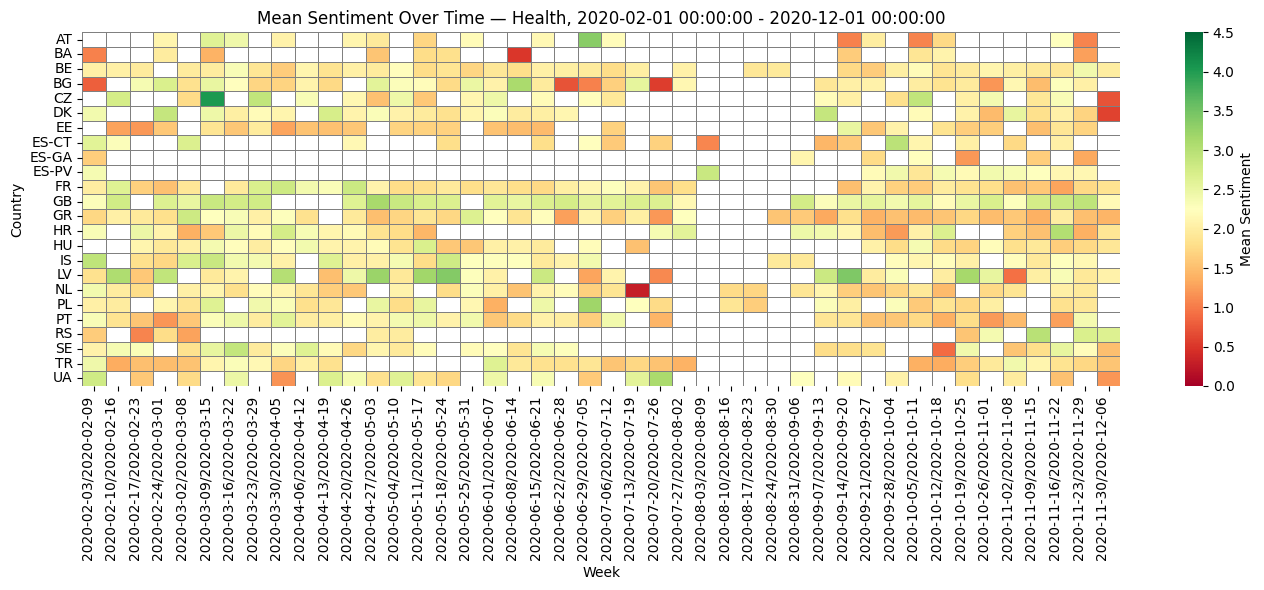

In [8]:
# ---- 1. Make sure 'date' is real datetime. This allows to extract the date as YYYY-MM-DD (without HH:MM:SS) ----
category_over_time["date"] = pd.to_datetime(category_over_time["date"], errors="coerce")
category_over_time["week"] = category_over_time["date"].dt.to_period("W")

# ---- 2. Pivot the data to get a matrix (countries as rows, weeks as columns) ----
# force all dates to first day of the week
heatmap_data = category_over_time.pivot_table(
    index="country",
    columns="week",          # <- monthly periods (no time-of-day)
    values="mean_sent",
    aggfunc="mean"
)

# ---- 3. (Optional) Make the column labels plain strings like '2023-09' ----
heatmap_data.columns = heatmap_data.columns.astype(str)

# ---- 4. Plot Heatmap ----
plt.figure(figsize=(14, 6))
sns.heatmap(
    heatmap_data,
    cmap="RdYlGn",
    vmin=0,  
    vmax=4.5,
    annot=False,    # set to True if you want numbers on each cell              
    cbar_kws={'label':'Mean Sentiment'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title(f"Mean Sentiment Over Time — {category}, {custom_start} - {custom_end}")
plt.xlabel("Week")
plt.ylabel("Country")
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()


**6. Choose single country: Average sentiment per country x CAP category**

Compute **mean sentiment for each CAP category** for one chosen country and visualize using **heatmaps** to identify what topics have had sentiment shifts or outliers over time.

C:\Users\isabe\AppData\Local\Temp\ipykernel_19388\1745389434.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_sentiment = country_df.groupby(['week', 'CAP_category'])['sent_logit'].mean().reset_index()


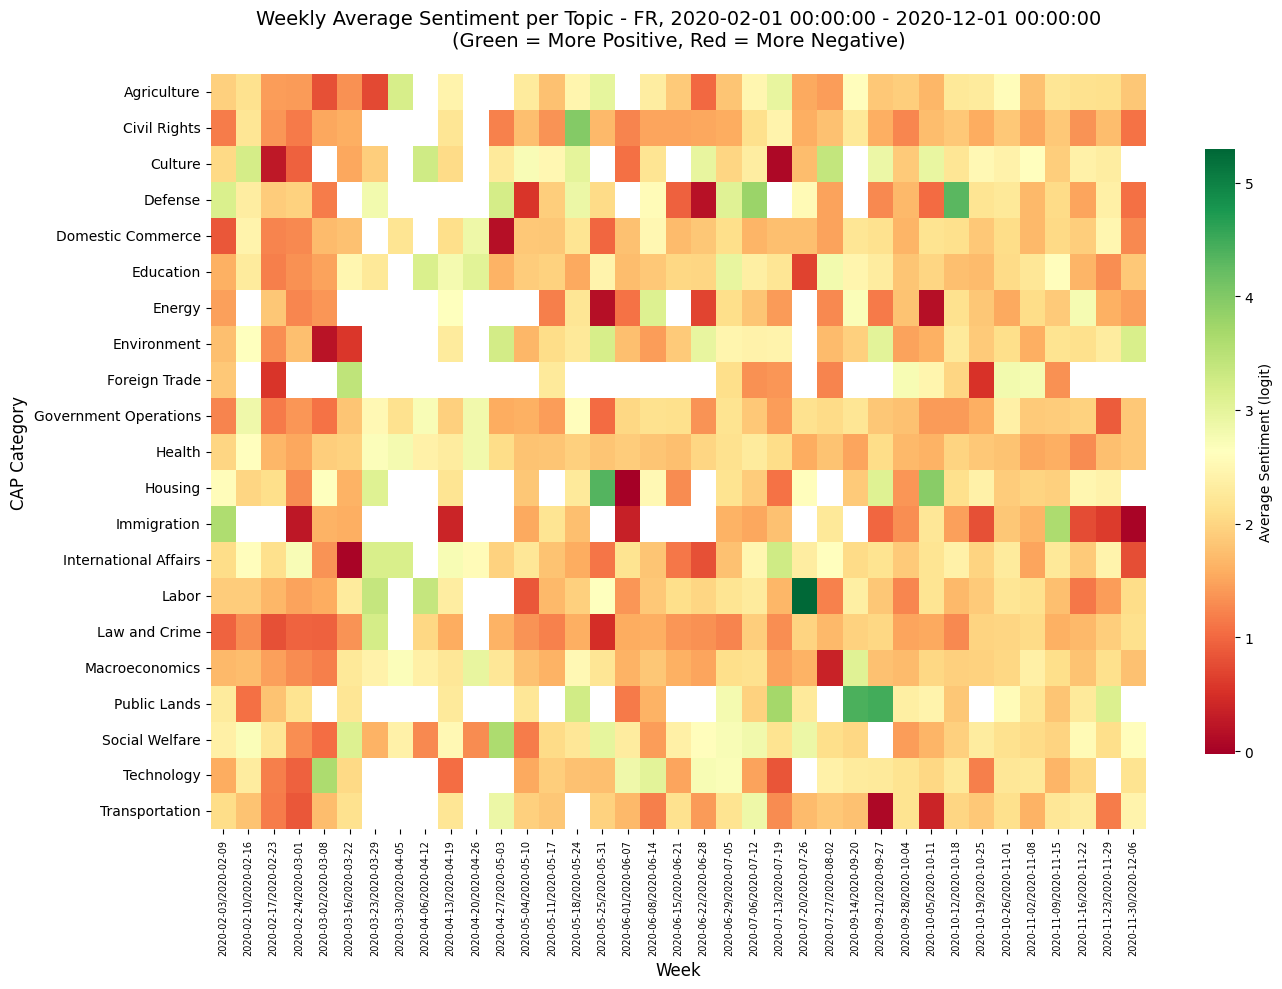

In [9]:
# ---- 1. Choose a target country ----
target_country = "FR"  # Change this to any country code: "DE", "IT", "GB", etc.

# ---- 2. Filter for the country and ensure date is datetime ----
country_df = filtered_all_custom[filtered_all_custom['country'] == target_country].copy()
country_df['date'] = pd.to_datetime(country_df['date'])
country_df['week'] = country_df['date'].dt.to_period('W').astype(str) # Create a 'week' period column

# ---- 3. Group by Week and CAP Category, calculate mean sentiment ----
weekly_sentiment = country_df.groupby(['week', 'CAP_category'])['sent_logit'].mean().reset_index()

# ---- 4. Pivot the table: Weeks as rows, CAP Categories as columns ----
heatmap_data_country = weekly_sentiment.pivot(index='week', columns='CAP_category', values='sent_logit')

# ---- 5. Plot the heatmap ----
plt.figure(figsize=(14, 10))  

sns.heatmap(
    heatmap_data_country.T,  
    cmap="RdYlGn",                      
    cbar_kws={"label": "Average Sentiment (logit)", "shrink": 0.8},
    square=False           
)

plt.title(f'Weekly Average Sentiment per Topic - {target_country}, {custom_start} - {custom_end}\n(Green = More Positive, Red = More Negative)', fontsize=14, pad=20)
plt.xlabel("Week", fontsize=12)
plt.ylabel("CAP Category", fontsize=12)
plt.xticks(rotation=90, ha='center', fontsize=7)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**7. Avg. weekly word count (for all countries)**

Compute the **weekly average number of words** spoken in each country's parliament and visualizes it as a **heatmap**, where each row is a country and each column is a week.

C:\Users\isabe\AppData\Local\Temp\ipykernel_19388\1311150232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_all_custom['date'] = pd.to_datetime(filtered_all_custom['date'])
C:\Users\isabe\AppData\Local\Temp\ipykernel_19388\1311150232.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_all_custom['week'] = filtered_all_custom['date'].dt.to_period('W').astype(str)


             date                   week
131456 2020-03-15  2020-03-09/2020-03-15
131457 2020-03-15  2020-03-09/2020-03-15
131458 2020-03-15  2020-03-09/2020-03-15
131459 2020-03-15  2020-03-09/2020-03-15
131460 2020-03-15  2020-03-09/2020-03-15


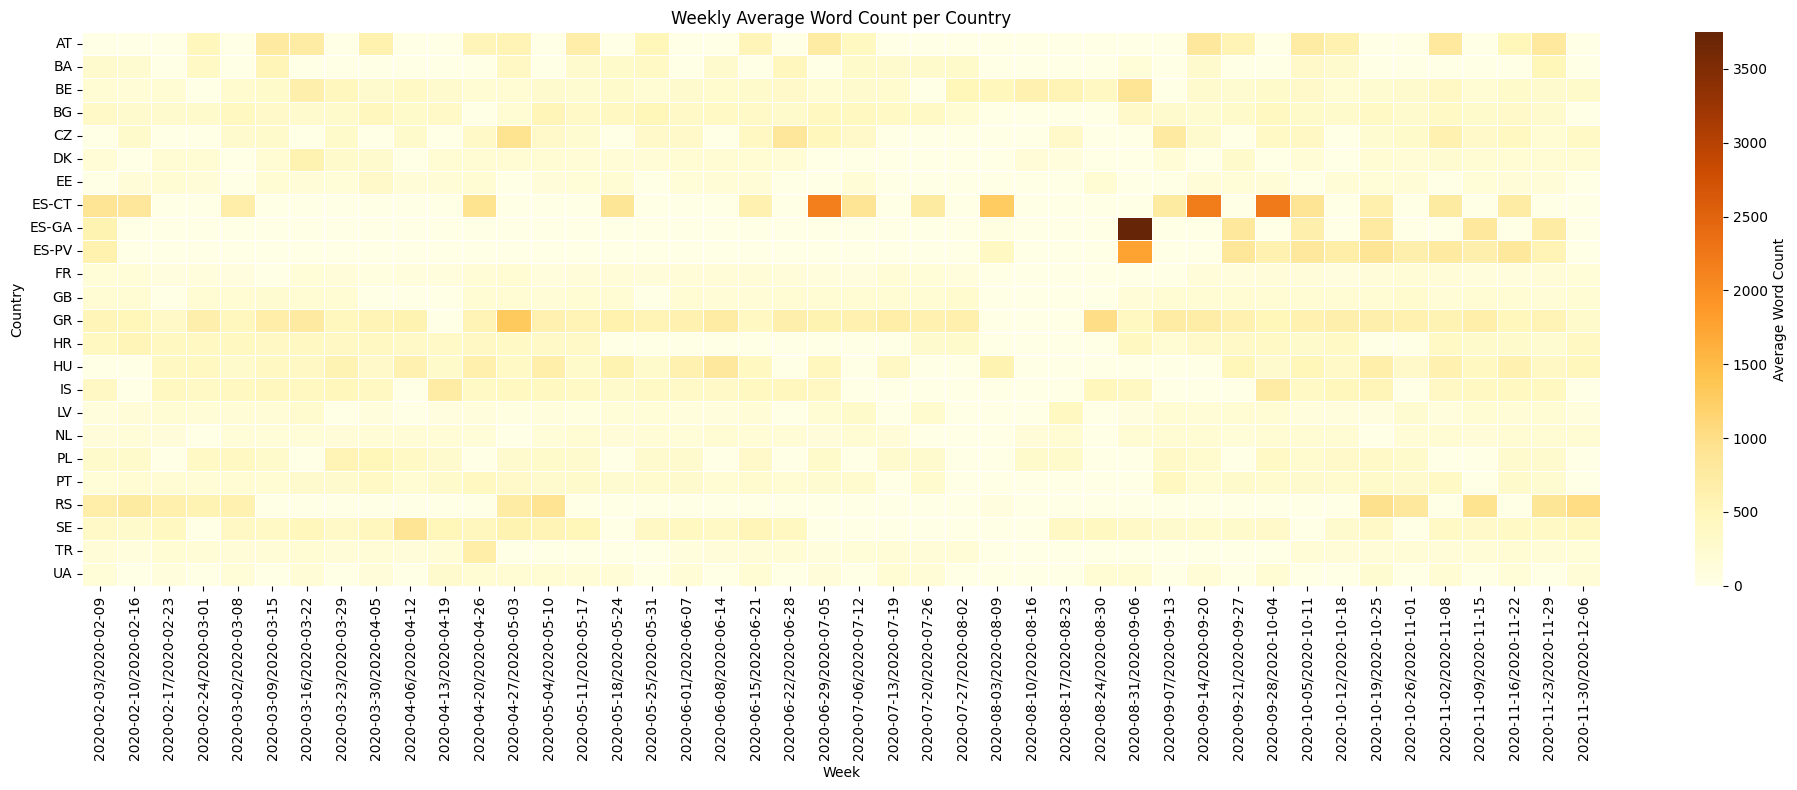

In [10]:
# 1. Ensure 'date' is datetime
filtered_all_custom['date'] = pd.to_datetime(filtered_all_custom['date'])

# 2. Create a 'week' column (ISO week)
filtered_all_custom['week'] = filtered_all_custom['date'].dt.to_period('W').astype(str)

# 3. Check it exists
print(filtered_all_custom[['date', 'week']].head())


# All countries heatmap
country_weekly = (
    filtered_all_custom
    .groupby(['country', 'week'])['word_count']
    .mean()
    .reset_index()
)

country_weekly_pivot = country_weekly.pivot(index='country', columns='week', values='word_count')
country_weekly_pivot = country_weekly_pivot.fillna(0).astype(float)  # <- fix here

plt.figure(figsize=(20,8))
sns.heatmap(
    country_weekly_pivot,
    cmap="YlOrBr",
    cbar_kws={'label': 'Average Word Count'},
    linewidths=0.5
)
plt.title("Weekly Average Word Count per Country")
plt.xlabel("Week")
plt.ylabel("Country")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**8. Avg. weekly word count for one country (and all topics)**

C:\Users\isabe\AppData\Local\Temp\ipykernel_19388\3965450774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_all_custom['date'] = pd.to_datetime(filtered_all_custom['date'])
C:\Users\isabe\AppData\Local\Temp\ipykernel_19388\3965450774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_all_custom['week'] = filtered_all_custom['date'].dt.to_period('W').astype(str)
C:\Users\isabe\AppData\Local\Temp\ipykernel_19388\3965450774.py:12: FutureWarning: The default of observed=False is deprecat

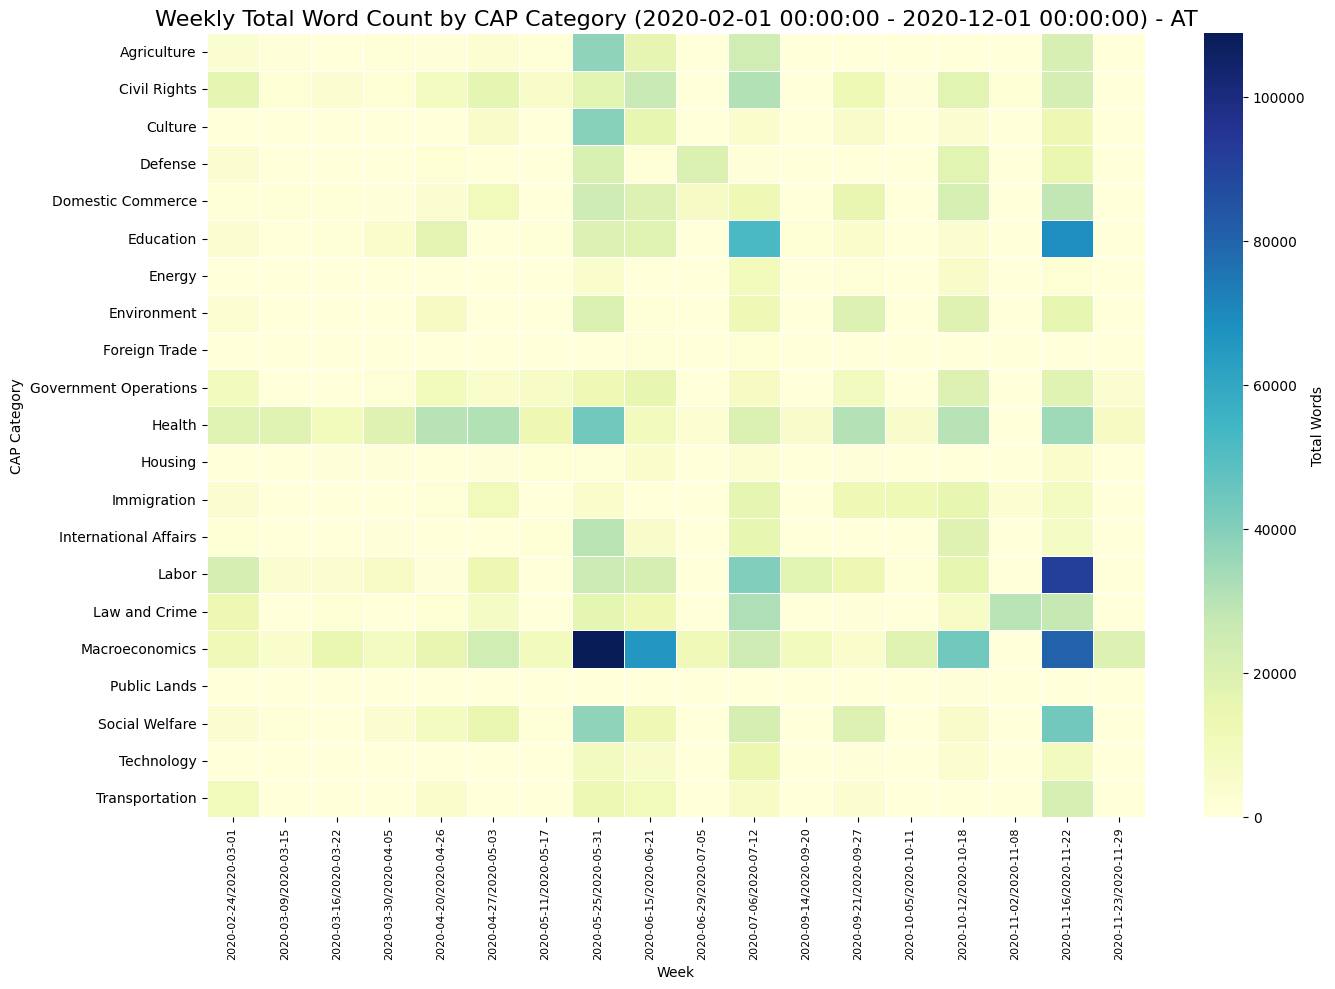

In [11]:
# ----- 1. Ensure 'date' is datetime and create 'week' -----
filtered_all_custom['date'] = pd.to_datetime(filtered_all_custom['date'])
filtered_all_custom['week'] = filtered_all_custom['date'].dt.to_period('W').astype(str)

# ----- 2. Choose a target country -----
target_country = "AT"  # Change to any country code you want
country_df = filtered_all_custom[filtered_all_custom['country'] == target_country].copy()

# ----- 3. Aggregate total word count by week and CAP category -----
weekly_wordcount = (
    country_df
    .groupby(['week', 'CAP_category'])['word_count']
    .sum()
    .reset_index()
)

# ----- 4. Pivot to have weeks as columns and CAP categories as rows -----
heatmap_data = weekly_wordcount.pivot(index='CAP_category', columns='week', values='word_count')
heatmap_data = heatmap_data.fillna(0).astype(float)  # fill missing weeks with 0

# ----- 5. Plot heatmap -----
plt.figure(figsize=(14,10))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    cbar_kws={'label': 'Total Words'},
    linewidths=0.5
)

plt.title(f"Weekly Total Word Count by CAP Category ({custom_start} - {custom_end}) - {target_country}", fontsize=16)
plt.xlabel("Week")
plt.ylabel("CAP Category")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()